# Question 2 (50%)
In this exercise, you will train two support vector machine (SVM) classifiers and assess/compare
their test performances. These SVMs wil respectively have linear and spherically-symmetric Gaussian (shaped radial basis function) kernels. We will refer to them as Linear-SVM and GaussianSVM. The data vectors are two-dimensional real-valued. The data distributions for the two classes
are as follows: (1) data from class −1 are drawn from a Gaussian with zero-mean and identitycovariance-matrix; (2) data from class +1 are generated using a two-step procedure: a radius value
is drawn from a uniform distribution over the interval [2,3] and an angle value (in radians) is drawn
from a uniform distribution over the interval [−π,π]; these radius and angle values are converted
to Cartesian coordinates using the Polar-to-Cartesian coordinate transformation rule.

1. Generate a training set with 1000 independent samples from these two class distributions
with priors q− = 0.35 and q+ = 0.65; note that this does not mean 350 samples from one
class and 650 from the other – the class label needs to be randomly selected for each sample,
in accordance with this prior. Visualize your training data.
2. Using 10-fold cross-validation, and minimum probability of error as the objective, select the
hyper parameters for both Linear-SVM and Gaussian-SVM. For both classifiers, the constraint violation term weight (usually dwnoted by C; sometimes called the overlap penalty
weight; referred to as the box constraint parameter in Matlab’s fitcsvm) must be optimized.
For the Gaussian kernel, the scale parameter (usually denoted by σ, corresponds to the standard deviation, if this Gaussian was a probability distribution) needs to be optimized. Visualize your cross-validation process in search of optimal hyperparameter values. Report the
smallest probability of error estimate you get from cross-validation.
3. Using the best hyperparameters you identified, train your Linear-SVM and Gaussian-SVM
using all of the training dataset. Visualize classification results on training data, count the
erroneously classified samples and report the training dataset probability of error estimate.
4. Generate 1000 independent test samples from the same class distributions with the same
priors as in the training dataset. Apply the Linear-SVM and Gaussian-SVM classifiers to the
test data samples. Visualize the performance of your classifiers on the test dataset and report
your test probability of error estimate.

In [1]:
# importing the necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import math
from sklearn.model_selection import GridSearchCV
import copy

## 1. 
Generate a training set with 1000 independent samples from these two class distributions with priors q− = 0.35 and q+ = 0.65; note that this does not mean 350 samples from one class and 650 from the other – the class label needs to be randomly selected for each sample, in accordance with this prior. Visualize your training data.

In [2]:
# data vector 1
q0 = 0.35
def data_class_one(size):
    mean = [0, 0]
    cov = [[1, 0], [0, 1]]
    return np.random.multivariate_normal(mean, cov, size)

In [3]:
#data vector 2
q1 = 0.65
def data_class_two(size):
    data = []
    for i in range(size):
        r = np.random.uniform(2, 3)
        angle = np.random.uniform(-math.pi, math.pi)
        x = r * math.cos(angle)
        y = r * math.sin(angle)
        data.append([x, y])
    return np.array(data)

In [4]:
# Generating the data
uniform_dis = np.random.uniform(0, 1, 1000)
data1 = data_class_one(len(uniform_dis[uniform_dis<=q0]))
data2 = data_class_two(len(uniform_dis[uniform_dis>q0]))
dataset = np.vstack([data1, data2])

In [5]:
data_class_dist = [len(data1), len(data2)]
print('The distirbution of data into class 1 and 2 is as follows: {}'.format(data_class_dist))
label1 = np.zeros([data_class_dist[0]]).tolist()
label2 = np.ones([data_class_dist[1]]).tolist()
label = np.array(label1 + label2)


The distirbution of data into class 1 and 2 is as follows: [342, 658]


In [6]:
data_and_label = np.hstack([dataset, label[:, None]])

Text(0.5, 1.0, 'Visualization of the Bivariate Dataset generated by two different methods')

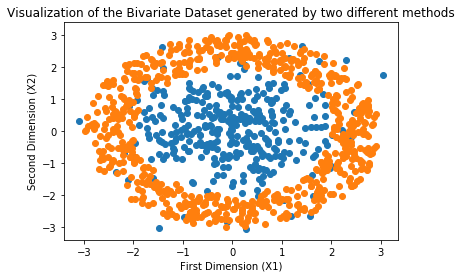

In [7]:
plt.scatter(data1[:, 0], data1[:, 1], label='Class q-')
plt.scatter(data2[:, 0], data2[:, 1], label='Class q+')
plt.xlabel('First Dimension (X1)')
plt.ylabel('Second Dimension (X2)')
plt.title('Visualization of the Bivariate Dataset generated by two different methods')

## 2.
Using 10-fold cross-validation, and minimum probability of error as the objective, select the hyper parameters for both Linear-SVM and Gaussian-SVM. For both classifiers, the constraint violation term weight (usually dwnoted by C; sometimes called the overlap penalty weight; referred to as the box constraint parameter in Matlab’s fitcsvm) must be optimized. For the Gaussian kernel, the scale parameter (usually denoted by σ, corresponds to the standard deviation, if this Gaussian was a probability distribution) needs to be optimized. Visualize your cross-validation process in search of optimal hyperparameter values. Report the smallest probability of error estimate you get from cross-validation.

In [8]:
def partition_data(dataset, partitions):
    partition_width = len(dataset) / partitions
    partitioned_dataset = []
    partitioned_label = []
    for i in range(partitions):
        partitioned_dataset.append(dataset[int(i*partition_width):int((i+1)*partition_width)])
#         partitioned_label.append(label[int(i*partition_width):int((i+1)*partition_width)])
    return partitioned_dataset

In [14]:
def k_fold_cross_valid(data, C_list, kernel, Gamma_list=np.array([])):
    partitioned_data_and_label = partition_data(data, 10)
    K_C_list = []
    K_Gamma_list = []
    params = {}
    params['C'] = C_list
    if Gamma_list.size > 0:
        params['gamma'] = Gamma_list
    for i in range(10):
        k_data_and_label = copy.deepcopy(partitioned_data_and_label)
        val_data_and_label = k_data_and_label.pop()
#         print(np.array(k_data_and_label).shape, np.array(val_data_and_label).shape)
        train_data = []
        train_label = []
        [train_data.extend(dat) for dat in np.array(k_data_and_label)[:, :, :2]]
        [train_label.extend(lab) for lab in np.array(k_data_and_label)[:, :, 2]]
#         print(np.array(train_data).shape, np.array(train_label).shape)
        gs = GridSearchCV(SVC(kernel=kernel), params)
#         l = np.array(train_label).astype(int)
#         print(train_data.shape, l.shape)
        gs.fit(train_data, train_label)
        val_preds = gs.predict(np.array(val_data_and_label)[:, :2])
    return gs, val_preds, np.array(val_data_and_label)[:, 2]

In [10]:
# C_list = [0.0001, 0.001, 0.01, 0.1, 1, 1.1, 1.01, 1.001, 1.0001, 2, 10]
# Gamma_list = [0.1, 0.3, 0.4, 0.6, 0.8, 1.0, 1.2]
C_list = np.logspace(-2, 10, 5)
Gamma_list = np.logspace(-9, 3, 5)

In [11]:
a, b, c = k_fold_cross_valid(data_and_label, C_list, 'rbf', Gamma_list=Gamma_list)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classif

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefined

In [13]:
a

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-02, 1.e+01, 1.e+04, 1.e+07, 1.e+10]),
                         'gamma': array([1.e-09, 1.e-06, 1.e-03, 1.e+00, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
a1, b1, c1 = k_fold_cross_valid(data_and_label, C_list, 'rbf', Gamma_list=Gamma_list)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
